## Streetview House Number Recognition

### Data Preprocessing

In this file we'd fetch and pre-process the Street View House Numbers (SVHN) data.

Data: Street View House Numbers (SVHN): A large-scale dataset of house numbers in Google Street View images.
With a heavy reference to https://github.com/hangyao/street_view_house_numbers

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import scipy.io as sio
import seaborn  

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [39]:


train = sio.loadmat("train_32x32.mat")
test = sio.loadmat("test_32x32.mat")
extra = sio.loadmat("extra_32x32.mat")

In [40]:
train_data = train['X']
train_labels = train['y']
test_data = test['X']
test_labels = test['y']
extra_data = extra['X']
extra_labels = extra['y']

In [41]:
print (train_data.shape, train_labels.shape)
print (test_data.shape, test_labels.shape)
print (extra_data.shape, extra_labels.shape)


(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)
(32, 32, 3, 531131) (531131, 1)


2 8


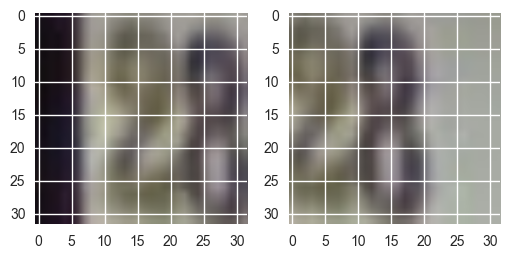

In [42]:
print (train['y'][12][0],train['y'][13][0])

f, axarr = plt.subplots(1,2)
axarr[0].imshow(train['X'][:,:,:,12])
axarr[1].imshow(train['X'][:,:,:,13])

In [43]:
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

In [44]:
# Build Validation Dataset and Labels Based on the Methods in This Paper:
# [https://arxiv.org/pdf/1204.3968.pdf]

# The SVHN classification dataset [8] contains 32x32
# images with 3 color channels. The dataset is divided
# into three subsets: train set, extra set and test set. The
# extra set is a large set of easy samples and train set is
# a smaller set of more difficult samples. Since we are
# given no information about how the sampling of these
# images was done, we assume a random order to construct
# our validation set. We compose our validation
# set with 2/3 from training samples (400 per class) and
# 1/3 from extra samples (200 per class), yielding a total
# of 6000 samples. This distribution allows to measure
# success on easy samples but puts more emphasis on dif-
# ficult ones.
# Samples are pre-processed with a local contrast normalization
# (with a 7x7 kernel) on the Y channel of the
# YUV space followed by a global contrast normalization
# over each channel. No sample distortions were used to
# improve invariance


import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,0] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,0] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,0] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,0] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_data = np.concatenate((extra_data[:,:,:,valid_index2], train_data[:,:,:,valid_index]), axis=3).transpose((3,0,1,2))
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)[:,0]
train_data_t = np.concatenate((extra_data[:,:,:,train_index2], train_data[:,:,:,train_index]), axis=3).transpose((3,0,1,2))
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)[:,0]
test_data = test_data.transpose((3,0,1,2))
test_labels = test_labels[:,0]

print(train_data_t.shape, train_labels_t.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(598388, 32, 32, 3) (598388,)
(26032, 32, 32, 3) (26032,)
(6000, 32, 32, 3) (6000,)


(array([ 600.,  600.,  600.,  600.,  600.,  600.,  600.,  600.,  600.,  600.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

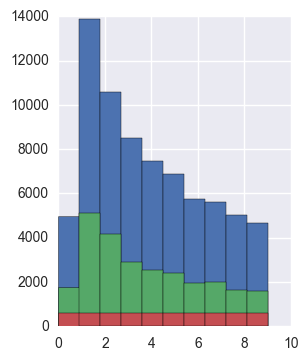

In [104]:

from pylab import rcParams
rcParams['figure.figsize'] = 3, 4

# plt.tight_layout()
plt.hist(train_labels)
plt.hist(test_labels)
plt.hist(valid_labels)

The class distributions for the three looks quite unbalanced (except for test set). Ideally we'd want to have close to uniform class distributions. #FutureWork

In [65]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    # Use the Conversion Method in This Paper:
    # [http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf]
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(train_data_t)[:,:,:,0]
test_data_c = im2gray(test_data)[:,:,:,0]
valid_data_c = im2gray(valid_data)[:,:,:,0]

print(train_data_c.shape, train_labels_t.shape)
print(test_data_c.shape, test_labels.shape)
print(valid_data_c.shape, valid_labels.shape)

(598388, 32, 32) (598388,)
(26032, 32, 32) (26032,)
(6000, 32, 32) (6000,)


In [66]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""
    
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_GCN

train_data_GCN = GCN(train_data_c)
test_data_GCN = GCN(test_data_c)
valid_data_GCN = GCN(valid_data_c)

print(train_data_GCN.shape, train_labels_t.shape)
print(test_data_GCN.shape, test_labels.shape)
print(valid_data_GCN.shape, valid_labels.shape)

(598388, 32, 32) (598388,)
(26032, 32, 32) (26032,)
(6000, 32, 32) (6000,)


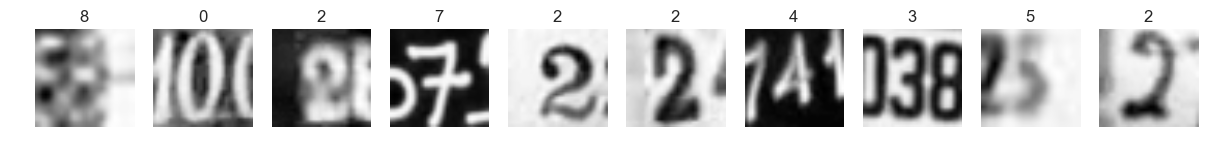

In [67]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels_t.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels_t[j], loc='center')
    ax[i].imshow(train_data_GCN[j,:,:])

### Storing Dataset


Here we store dataset for future use. Training dataset is quite big and we'd get an error when we try to save it as whole. So we'll break it into chuncks and save each piece separately. 



In [92]:
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    #'train_dataset': train_data_GCN,
    'train_labels': train_labels_t,
    'valid_dataset': valid_data_GCN,
    'valid_labels': valid_labels,
    'test_dataset': test_data_GCN,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 263036951


In [93]:
pickle_file = 'SVHN1.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset1': train_data_GCN[:200000],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1638400161


In [94]:
pickle_file = 'SVHN2.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset2': train_data_GCN[200000:400000],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1638400161


In [95]:
pickle_file = 'SVHN3.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset3': train_data_GCN[400000:],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 1625194657


### Off the shelf classifier 

Before jumping into more complicated solutions (e.g. NN), let's have a feel of how a standard off the shelf classifier performs in classifying this dataset. 



In [90]:
from sklearn.linear_model import LogisticRegression

num_samples = 10000
(samples, width, height) = train_data_GCN.shape
X = np.reshape(train_data_GCN,(samples,width*height))[0:num_samples]

lrc  = LogisticRegression()
lrc.fit(X,train_labels_t[0:num_samples])

(samples, width, height) = test_data_GCN.shape
Xprime = np.reshape(test_data_GCN,(samples,width*height))

score = lrc.score(Xprime,test_labels)
print ("Mean accuracy with %d samples: " %num_samples , score)

Mean accuracy with 10000 samples:  0.190611555009


As it turns out, pretty bad, so we'd next try a fully connected and convolutional neural network. (continued in another notebook)